In [1]:
import numpy as np
from matplotlib.pylab import *
import random
import scipy.io

# Import Statsmodel
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

font = {'family' : 'normal',
        'size'   : 22}

In [2]:
# Function to Under-Sample Experimental Measurements
def underSample_LZT(X, Y, timeIns, t_max, t_Force, underSamp_Factor):
    timeSamp = np.where(timeIns <= t_max)[0][-1]
    timeIns_UnderSamp = timeIns[0:timeSamp]
    idx_Forcing = np.where(timeIns_UnderSamp <= t_Force)
    idx_unForced = np.where(timeIns_UnderSamp > t_Force)

    # Under-Sampling Input
    iX_underSampled = np.concatenate([idx_Forcing[0], idx_unForced[0][range(0, idx_unForced[0].size, underSamp_Factor)]])
    X_UnderSamp = X[iX_underSampled, :]
    timeIns_UnderSamp = timeIns_UnderSamp[iX_underSampled]

    # Under-Sampling Output
    shift_outType = int(Y.shape[0]/3)
    iY_underSampled = np.concatenate([iX_underSampled, shift_outType + iX_underSampled, 2*shift_outType+iX_underSampled])
    Y_UnderSamp = Y[iY_underSampled, :]
    
    return(timeIns_UnderSamp, X_UnderSamp, Y_UnderSamp, iX_underSampled, iY_underSampled)

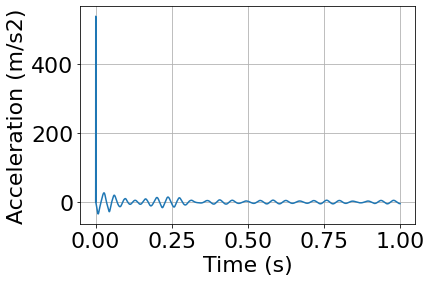

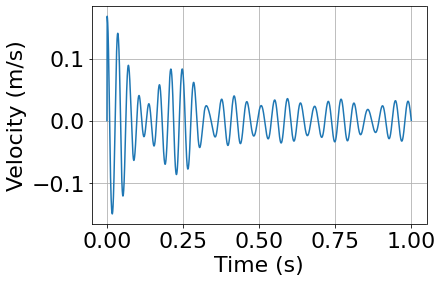

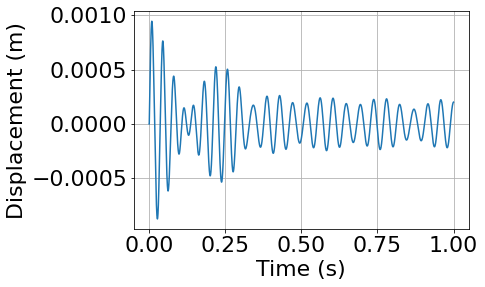

In [84]:
# Load Simulation of Experimental System
TFAVX = np.loadtxt("2-Sim for Exp Sim/SimTFAVX_R0.txt", delimiter=",")

# Plot Acceleration
figure()
plt_acc = plot(TFAVX[:, 0], TFAVX[:, 2])
xlabel( 'Time (s)')
ylabel( 'Acceleration (m/s2)')
rc('font', **font)
grid('on')

# Plot Velocity
figure()
plt_acc = plot(TFAVX[:, 0], TFAVX[:, 3])
xlabel( 'Time (s)')
ylabel( 'Velocity (m/s)')
rc('font', **font)
grid('on')

# Plot Displacement
figure()
plt_acc = plot(TFAVX[:, 0], TFAVX[:, 4])
xlabel( 'Time (s)')
ylabel( 'Displacement (m)')
rc('font', **font)
grid('on')

In [73]:
# Create noise for Training

# Number of Training Set to create
timeSamp = TFAVX.shape[0]
N_Train = 100 # Needs to be a perfect square
wNoise_Train = np.zeros([timeSamp, N_Train])
transNoise_Train = np.zeros([timeSamp, N_Train])
aMeas_Train = np.zeros([timeSamp, N_Train])

# Reference Aceleration Parameters to Control Noise
max_Acc = np.max(np.abs(TFAVX[:, 2]))
transNoiseAmp_time = 100 * np.exp(-TFAVX[:, 0]/TFAVX[-1, 0] * 20)

# Noise Unvarying Parameters
mean = 0
std_Min = -1
std_Max = 1
RelAmp_Min = -3
RelAmp_Max = -2

# Noise parameters to vary between sets
stds_amp = np.logspace(std_Min, std_Max, np.int(np.sqrt(N_Train)) )
noise_RelAmp = np.logspace(RelAmp_Min, RelAmp_Max, np.int(np.sqrt(N_Train)) )

# Create Training Set
ii_Train = 0
for ii_NoiseAmp in range(noise_RelAmp.size):
    maxNoiseAmp = max_Acc * noise_RelAmp[ii_NoiseAmp]
    for ii_stdAmp in range(stds_amp.size):
        
        std = stds_amp[ii_stdAmp]
        
        # White Noise
        wNoise_Train[:, ii_Train] = np.random.normal(mean, std, size = timeSamp)
        noise_Max = np.max(np.abs(wNoise_Train[:, ii_Train]))
        wNoise_Train[:, ii_Train] = maxNoiseAmp * (wNoise_Train[:, ii_Train]/noise_Max)
        
        # Noise proportional to transiency
        transNoise_Train[:, ii_Train] = np.random.normal(mean, std, size = timeSamp)
        transNoise_Max = np.max(np.abs(transNoise_Train[:, ii_Train]))
        transNoise_Train[:, ii_Train] = maxNoiseAmp * (transNoise_Train[:, ii_Train]/transNoise_Max)
        transNoise_Train[:, ii_Train] = transNoiseAmp_time * transNoise_Train[:, ii_Train]
        
        # Measured Testing
        aMeas_Train[:, ii_Train] = TFAVX[:, 2] + wNoise_Train[:, ii_Train] + transNoise_Train[:, ii_Train]
        ii_Train = ii_Train + 1
        

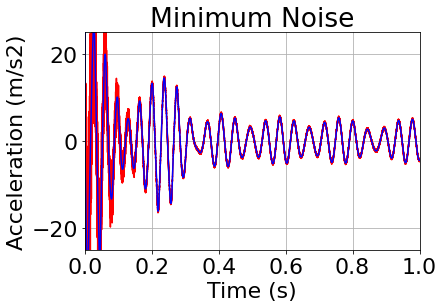

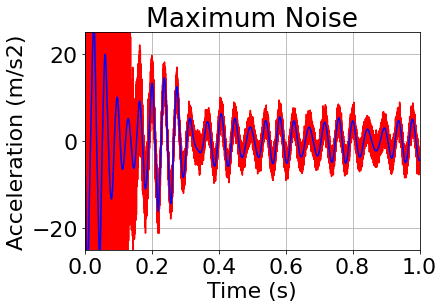

In [86]:
# Plot Minimum Noisy Data
figure()
plot(TFAVX[:, 0], aMeas_Train[:, 0], 'r-')
plot(TFAVX[:, 0], TFAVX[:, 2], 'b-')
xlabel( 'Time (s)')
ylabel( 'Acceleration (m/s2)')
grid('on')
xlim([0, 1])
ylim([-25, 25])
title('Minimum Noise')
rc('font', **font)
show()
       
# Plot Maximum Noisy Data
figure()
plot(TFAVX[:, 0], aMeas_Train[:, -1], 'r-')
plot(TFAVX[:, 0], TFAVX[:, 2], 'b-')
xlabel( 'Time (s)')
ylabel( 'Acceleration (m/s2)')
grid('on')
xlim([0, 1])
ylim([-25, 25])
title('Maximum Noise')
rc('font', **font)
show()

In [75]:
# Assemble Output
Y = np.reshape(TFAVX[:,2:].T, [timeSamp*3,1]) # Y_Train = [a_Actual; v_Actual; x_Actual]
Y_Train = np.kron(Y, np.ones([1, N_Train])) # Y_Train = [Y, Y, Y, ...]

# Under-Sampling Parameters
t_max = 1
t_Force = 0.002
underSamp_Factor = 10

# Apply Under-Sampling to Input and Output
time_UnderSamp, X_Train, Y_Train, iX_underSampled, iY_underSampled =(
    underSample_LZT(aMeas_Train, Y_Train, TFAVX[:,0],
                    t_max, t_Force, underSamp_Factor))

In [76]:
# Solve the Linear System: Y_Train = B X_Train or Y_Train' = X_Train' B'
ols_Solver = np.linalg.lstsq(X_Train.T, Y_Train.T)
B = ols_Solver[0].T

<ipython-input-76-d961c754eace>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_Solver = np.linalg.lstsq(X_Train.T, Y_Train.T)


In [77]:
# Assign Indices in the output for: a, v and x
size_Type = int(iX_underSampled.shape[0])
idxTrain_acc = range(0,size_Type)
idxTrain_vel = range(size_Type, 2*size_Type)
idxTrain_dis = range(2*size_Type, 3*size_Type)

# Compute References by getting Maximum values of:n a, v, x
max_acc = np.abs(Y_Train[idxTrain_acc, :]).max(axis = 0)
max_vel = np.abs(Y_Train[idxTrain_vel, :]).max(axis = 0)
max_dis = np.abs(Y_Train[idxTrain_dis, :]).max(axis = 0)

# Compute Residuals for every type of output
resTrain_avx = Y_Train - B.dot(X_Train)
resTrain_acc = np.linalg.norm(resTrain_avx[idxTrain_acc, :] / max_acc, axis = 0)
resTrain_vel = np.linalg.norm(resTrain_avx[idxTrain_vel, :] / max_vel, axis = 0)
resTrain_dis = np.linalg.norm(resTrain_avx[idxTrain_dis, :] / max_dis, axis = 0)

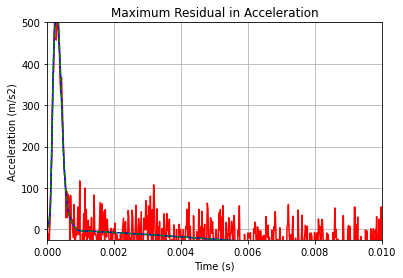

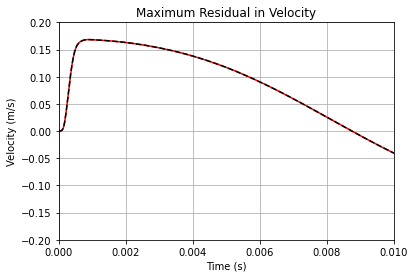

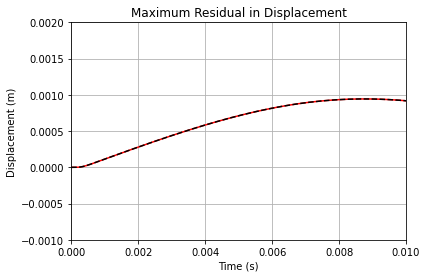

In [78]:
# Plot of maximum Residual Acceleration
idx_MaxRes = np.where(resTrain_acc == np.max(resTrain_acc))
idx_MaxRes = idx_MaxRes[0][0]

figure()
plot(TFAVX[:, 0], aMeas_Train[:, idx_MaxRes], 'r-')
plot(TFAVX[:, 0], TFAVX[:, 2], 'b-')
plot(time_UnderSamp, B.dot(X_Train[:, idx_MaxRes])[idxTrain_acc], 'g--')
xlabel( 'Time (s)')
ylabel( 'Acceleration (m/s2)')
grid('on')
xlim([0, 0.01])
ylim([-25, 500])
title('Maximum Residual in Acceleration')
show()

# Plot of maximum Residual in Velocity
idx_MaxRes = np.where(resTrain_vel == np.max(resTrain_vel))
idx_MaxRes = idx_MaxRes[0][0]

figure()
plot(TFAVX[:, 0], TFAVX[:, 3], 'r-')
plot(time_UnderSamp, B.dot(X_Train[:, idx_MaxRes])[idxTrain_vel], 'k--')
xlabel( 'Time (s)')
ylabel( 'Velocity (m/s)')
grid('on')
xlim([0, 0.01])
ylim([-0.2, 0.2])
title('Maximum Residual in Velocity')
show()


# Plot of maximum Residual in Displacement
idx_MaxRes = np.where(resTrain_dis == np.max(resTrain_dis))
idx_MaxRes = idx_MaxRes[0][0]

figure()
plot(TFAVX[:, 0], TFAVX[:, 4], 'r-')
plot(time_UnderSamp, B.dot(X_Train[:, idx_MaxRes])[idxTrain_dis], 'k--')
xlabel( 'Time (s)')
ylabel( 'Displacement (m)')
grid('on')
xlim([0, .01])
ylim([-1e-3, 2e-3])
title('Maximum Residual in Displacement')
show()

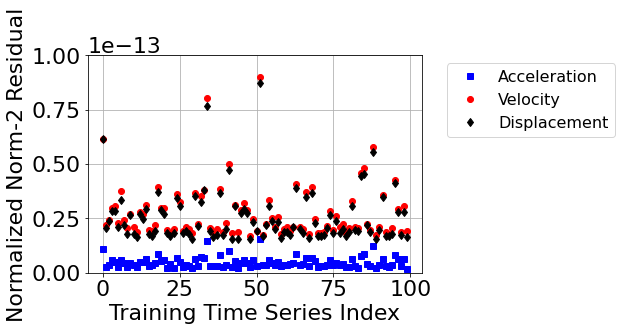

In [99]:
# Evaluate Performance on Training Set
figure()
plot(resTrain_acc, 'bs')
plot(resTrain_vel, 'ro')
plot(resTrain_dis, 'kd')
grid('on')
rc('font', **font)
ylim([0, 1e-13])
ylabel('Normalized Norm-2 Residual')
xlabel('Training Time Series Index')
legend(['Acceleration', 'Velocity', 'Displacement'],fontsize = 16, bbox_to_anchor=(1.05, 1), loc='upper left')
show()

In [101]:
# Load Experimental Raw Acceleration
iFstart = scipy.io.loadmat('1-Matlab Exp and RTS Results/iFstart.mat')
iFstart = iFstart['iFstart'][0][0] - 1 # Index when Forcing starts

aRaw_Exp = scipy.io.loadmat('1-Matlab Exp and RTS Results/aRAW_acc_R0.mat')
aRaw_Exp = aRaw_Exp['aRAW_acc_R0'][iFstart:]

time_Exp = scipy.io.loadmat('1-Matlab Exp and RTS Results/time.mat')
time_Exp = time_Exp['time']
dt_Exp = np.mean(np.diff(time_Exp[:,0]))
time_Exp = np.arange(aRaw_Exp.size) * dt_Exp

# Under-Sample Measurement in order to Apply Regression
timeExp_UnderSampled, X_Exp, _, iXexp_UnderSampled, iYexp_UnderSampled =(
    underSample_LZT(aRaw_Exp, np.zeros([3*aRaw_Exp.size, 1]), time_Exp,
                    t_max, t_Force, underSamp_Factor))

# Apply Regression to get the filtered: a, V and x
Y_ExpReg = B.dot(X_Exp)
size_ExpType = int(Y_ExpReg.shape[0]/3)
acc_ExpReg = Y_ExpReg[0:size_ExpType, :]
vel_ExpReg = Y_ExpReg[size_ExpType:(2*size_ExpType), :]
dis_ExpReg = Y_ExpReg[(2*size_ExpType):(3*size_ExpType), :]

In [103]:
# Load RTS Results
a_RTS = scipy.io.loadmat('1-Matlab Exp and RTS Results/a_acc_R0.mat')
a_RTS = a_RTS['a_acc_R0']

v_RTS = scipy.io.loadmat('1-Matlab Exp and RTS Results/v_acc_R0.mat')
v_RTS = v_RTS['v_acc_R0']

x_RTS = scipy.io.loadmat('1-Matlab Exp and RTS Results/x_acc_R0.mat')
x_RTS = x_RTS['x_acc_R0']

time_RTS = np.arange(a_RTS.size) * dt_Exp

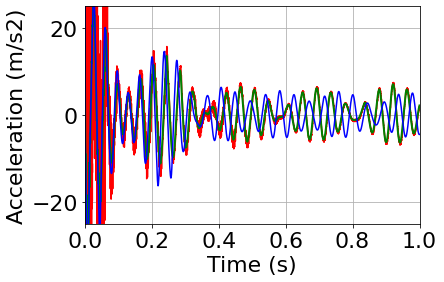

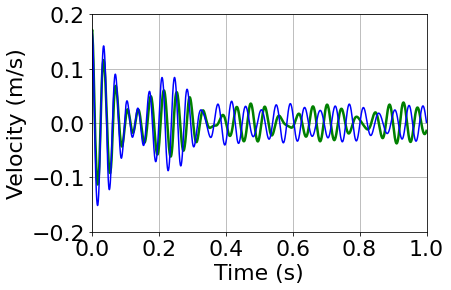

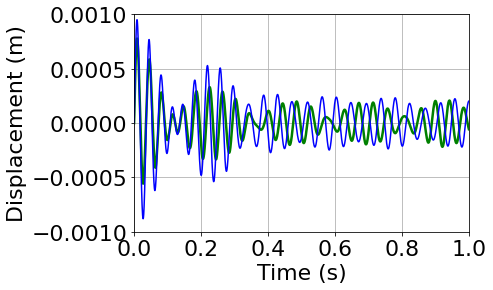

In [114]:
# Acceleration: Regression vs. Experiemtnal
figure()
plot(time_Exp, aRaw_Exp[range(time_Exp.size)], 'r-')
plot(time_RTS, a_RTS, 'g-', linewidth = 2)
plot(timeExp_UnderSampled, acc_ExpReg, 'b-')
xlabel( 'Time (s)')
ylabel( 'Acceleration (m/s2)')
grid('on')
xlim([0, 1])
ylim([-25, 25])
rc('font', **font)
show()

# Velocity: Regression vs. Experiemtnal
figure()
plot(time_RTS, v_RTS, 'g-', linewidth = 2.5)
plot(timeExp_UnderSampled, vel_ExpReg, 'b-')
xlabel( 'Time (s)')
ylabel( 'Velocity (m/s)')
grid('on')
xlim([0, 1])
ylim([-0.2, 0.2])
rc('font', **font)
show()


# Displacement: Regression vs. Experiemtnal
figure()
plot(time_RTS, x_RTS, 'g-', linewidth = 2.5)
plot(timeExp_UnderSampled, dis_ExpReg, 'b-')
xlabel( 'Time (s)')
ylabel( 'Displacement (m)')
grid('on')
xlim([0, 1])
ylim([-1e-3, 1e-3])
rc('font', **font)
show()